In [7]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

from models.zf_unet.zf_unet_224_model import ZF_UNET_224

In [5]:
filenames = glob.glob(os.path.join('../data/test_224', '*'))
selection = filenames[:10]

In [6]:
model = ZF_UNET_224()
model.load_weights('./weights_224_100epochs/temp.99--1.94.hdf5')

In [8]:
imgs = []
for fname in selection:
    imgs.append(io.imread(fname))
imgs = np.asarray(imgs)

In [12]:
masks = model.predict_on_batch(imgs)
print(masks.shape)

(10, 224, 224, 1)


In [22]:
masks_bin = np.squeeze(masks) > 0.5

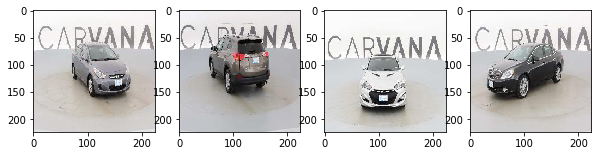

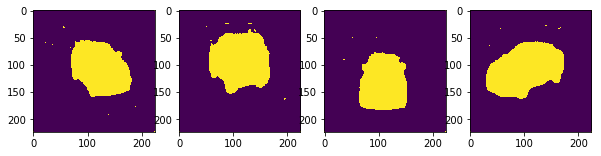

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 30))
for idx, img in enumerate(imgs[:4]):
    axes[idx].imshow(img)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 30))
for idx, mask in enumerate(masks_bin[:4]):
    axes[idx].imshow(mask)
plt.show()

# print(imgs.shape, masks.shape)
# print(imgs[0].shape, masks[0].shape)
# plt.imshow(masks[0])